Image processing class assignment:
Здійснити  R&D дослідження  та  реалізувати  програмний  скрипт  із  конкретикою 
методів і технологічних етапів  Computer  Vision:  вибір цифрового зображення та об’єкта 
ідентифікації;  завантаження  цифрового  зображення; покращення  якості  цифрового 
зображення;  векторизація  об’єкта  ідентифікації  –  встановлення  геометричної  ознаки; 
ідентифікація об’єкта за геометричною ознакою. 
Вибір цифрового зображення та об’єкту ідентифікації встановлено варіантами таблиці 
додатку. 
Для покращення якості цифрового зображення використовувати:  
корекцію кольору;  
корекцію гістограми яскравості (для всього зображення  (глобальна)  /  для сегменту 
зображення (локальна)); 
методи / алгоритми фільтрації зображень. 
Вибір переліку методів покращення якості має бути обґрунтованим та забезпечувати 
побудову контору об’єкту ідетифікації. 
Для векторизації зображення (визначення контуру) використовувати методи базових 
бібліотек python для обробки цифрових зображень; 
Ідентифікацію здійснювати за технологією порівняння геометричних ознак (контуру) 
образу та об’єкту ідентифікації.
Здійснити  виконання  завдання  лабораторної  роботи  для  статичного  цифрового 
зображення за варіантами таблиці додатку
Мій Варіант в таблиці:
Контент цифрового зображення / джерело: Дані ДЗЗ (дистанційного зодування землі)
Об’єкт ідентифікації: Об’єкти – лісові насадження


Video source: https://www.vecteezy.com/video/7997558-aerial-view-of-evergreen-coniferous-tree-forest-in-summer

In [185]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

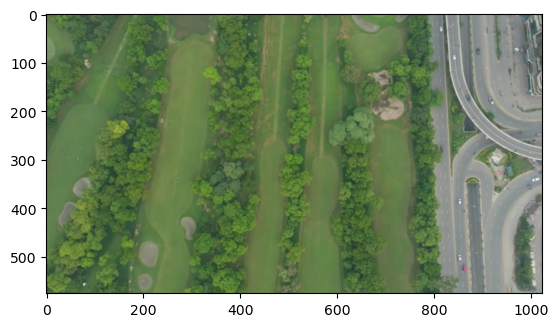

In [186]:
# Load the latest uploaded video and attempt to extract a frame
cap_latest = cv2.VideoCapture('assets\park2.mp4')

# Read the first frame from the latest video
success_latest, frame_latest = cap_latest.read()
cap_latest.release()

# Check success and convert to RGB if successful
frame_rgb = cv2.cvtColor(frame_latest, cv2.COLOR_BGR2RGB) if success_latest else None

# Check the result
frame_rgb.shape if frame_rgb is not None else "Failed to load frame from latest video"

plt.imshow(frame_rgb)

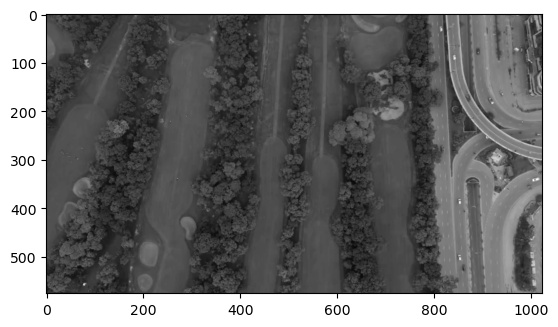

In [187]:
# Convert the image to grayscale
gray_img = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2GRAY)



# Display the image in grayscale
plt.imshow(gray_img, cmap='gray')

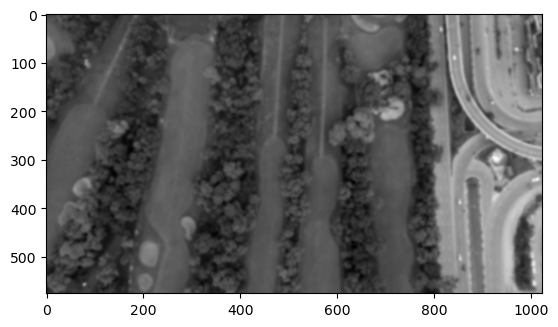

In [188]:
gaussian_img = cv2.GaussianBlur(gray_img, (13, 13), 0)
plt.imshow(gaussian_img, cmap='gray')
# plt.show()

This is manual implementation of equalizeHist. We can use it but it is not really as good as cv2 version

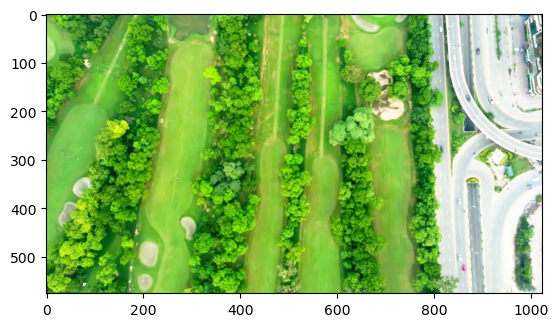

In [200]:
def hist_equal_man(frame_rgb):
    hist,bins = np.histogram(frame_rgb.flatten(),256,[0,256])
    cdf = hist.cumsum()
    # the next line formalizes cdf so that the max value of cdf_normalized is equal to  the maximum value of the histogram (hist.max())
    # normalization here(in this part of code) is only done for the plotting purposes. 
    cdf_normalized = cdf * hist.max()/ cdf.max()        # Визначення нормалізоуючої кривої
    cdf_masked = np.ma.masked_equal(cdf,0)
    cdf_masked_normalized = (cdf_masked - cdf_masked.min())*255/(cdf_masked.max()-cdf_masked.min())
    cdf_normalized = np.ma.filled(cdf_masked_normalized,0).astype('uint8')
    img2 = cdf_normalized[frame_rgb]
    
    return img2

plt.imshow(hist_equal_man(frame_rgb))

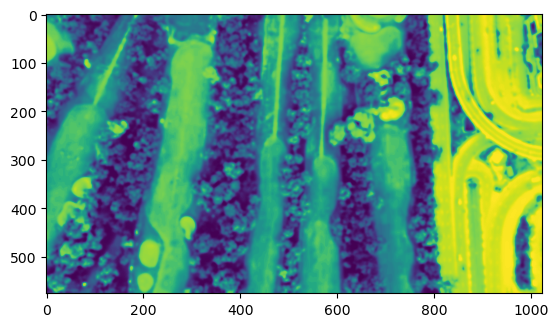

In [190]:
equ_gray_img = cv2.equalizeHist(gaussian_img)
plt.imshow(equ_gray_img)

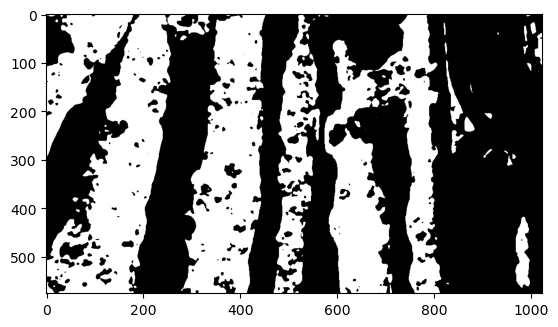

In [191]:
# Apply thresholding to get a binary image
_, binary_img = cv2.threshold(equ_gray_img, 110, 255, cv2.THRESH_BINARY)
inverted_img = cv2.bitwise_not(binary_img)
plt.imshow(inverted_img, cmap='gray')

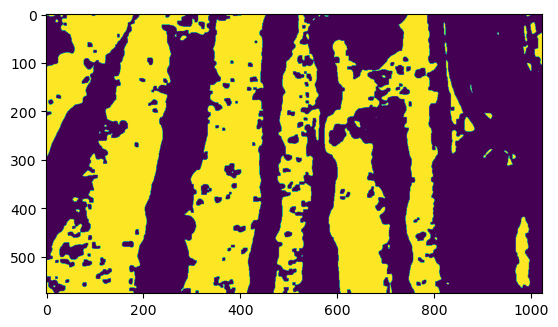

In [192]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))      # робота із внутрішньою структурою зображення
closed = cv2.morphologyEx(inverted_img, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed)
plt.show()

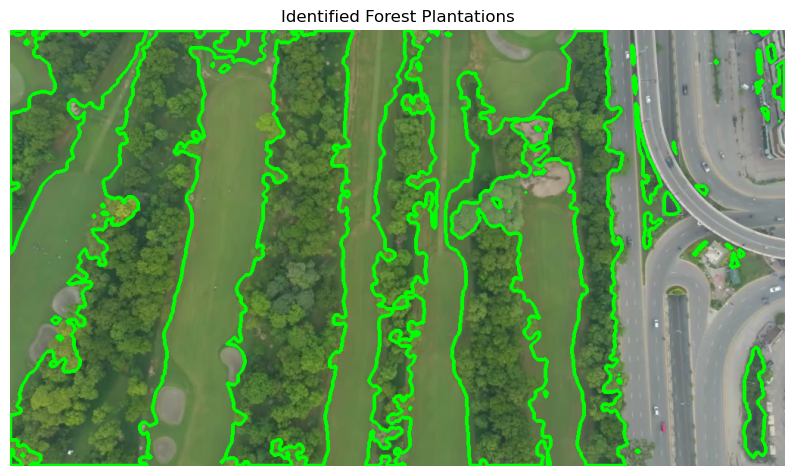

In [193]:

# Find contours in the binary image
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
contour_img = frame_rgb.copy()
cv2.drawContours(contour_img, contours, -1, (0,255,0), 3)

plt.figure(figsize=(10, 6))
plt.imshow(contour_img)
plt.title('Identified Forest Plantations')
plt.axis('off')
plt.show()

In [194]:
# Функція для обрахунку характеристик контуру
def contour_properties(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    compactness = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
    # is_rect = False
    
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    rect_area = rect[1][0] * rect[1][1]  # Ширина * Висота
    
    if rect_area>0:
        rectangularity = area / rect_area
    else:
        rectangularity = None
        
    return area, compactness, rectangularity

contour_props = [contour_properties(cnt) for cnt in contours]

contour_props_sorted = sorted(contour_props, key=lambda x: x[0])
    
print(len(contour_props))
contour_props_sorted[-10:]


52


C:\Users\vikto\AppData\Local\Temp\ipykernel_4660\3852920344.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


[(397.5, 0.7189193322449627, 0.6853448275862069),
 (431.0, 0.28893894917455226, 0.40310514619625165),
 (485.0, 0.26985132037328363, 0.5412946428571429),
 (1180.5, 0.1505314167904052, 0.354273718645134),
 (2871.5, 0.28952047079414434, 0.6828775267538645),
 (20607.5, 0.2542773680864747, 0.4791758558133489),
 (25131.0, 0.05762921806933277, 0.5248986307936787),
 (63162.5, 0.19104463531839827, 0.7010057107041302),
 (69359.0, 0.06600115027760964, 0.5111117232059944),
 (70479.5, 0.13842612381391173, 0.5687513321368206)]

C:\Users\vikto\AppData\Local\Temp\ipykernel_4660\3852920344.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


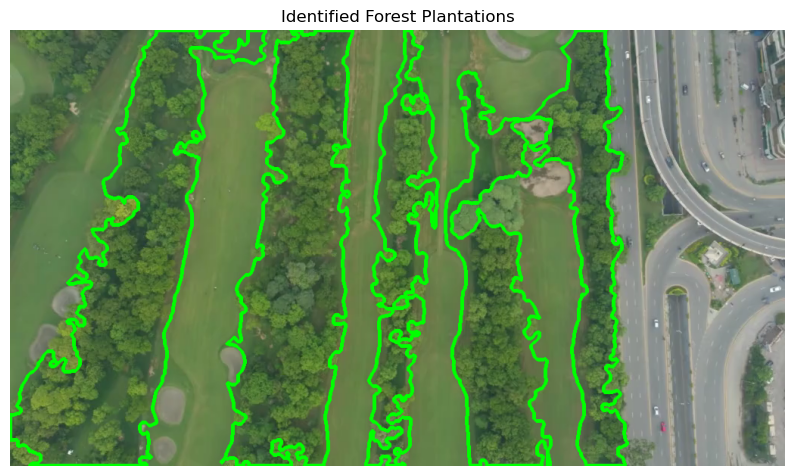

In [195]:
def filter_contours(contours):
    min_area = 15000
    mаx_compactness = 0.25  # Компактність ближча до 1 означає більш круглу форму
    min_rectangularity = 0.4
    # Фільтрація контурів, що відповідають критеріям насаджень

    forest_contours = []
    for cnt in contours:
        area, compactness, rectangularity = contour_properties(cnt)
        if area>min_area and compactness< mаx_compactness and rectangularity> min_rectangularity:
            forest_contours.append(cnt)
            
            
    return forest_contours

# forest_contours = [cnt for cnt in contours if contour_properties(cnt)[0] > min_area and contour_properties(cnt)[1] < mаx_compactness and contour_properties(cnt)[2] > min_rectangularity]

# Намалювати контури насаджень на оригінальному зображенні
forest_img = frame_rgb.copy()
cv2.drawContours(forest_img, filter_contours(contours), -1, (0, 255, 0), 3)

# Показати результат
plt.figure(figsize=(10, 6))
plt.imshow(forest_img)
plt.title('Identified Forest Plantations')
plt.axis('off')
plt.show()

Now let's replicate all the steps for a video.

In [196]:
input_video_path = 'assets/park2.mp4'
output_video_path = 'output/park2_processed.mp4'

In [197]:
cap = cv2.VideoCapture(input_video_path)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (frame_width, frame_height))

while True:
    success, frame = cap.read()
    if not success:
        break

    # Процес обробки кадру
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gaussian_img = cv2.GaussianBlur(gray_img, (13, 13), 0)
    equ_gray_img = cv2.equalizeHist(gaussian_img)
    _, binary_img = cv2.threshold(equ_gray_img, 110, 255, cv2.THRESH_BINARY)
    inverted_img = cv2.bitwise_not(binary_img)

    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # closed = cv2.morphologyEx(inverted_img, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(inverted_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(frame, filter_contours(contours), -1, (0, 255, 0), 3)

    # Запис кадру в вихідний файл
    out.write(frame)

# Закрити всі потоки
cap.release()
out.release()
cv2.destroyAllWindows()


C:\Users\vikto\AppData\Local\Temp\ipykernel_4660\3852920344.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [199]:
# hist,bins = np.histogram(frame_rgb.flatten(),256,[0,256])
# cdf = hist.cumsum()
# # the next line formalizes cdf so that the max value of cdf_normalized is equal to  the maximum value of the histogram (hist.max())
# # normalization here(in this part of code) is only done for the plotting purposes. 
# cdf_normalized = cdf * hist.max()/ cdf.max()        # Визначення нормалізоуючої кривої
# plt.plot(cdf_normalized, color = 'b')
# plt.hist(frame_rgb.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')
# plt.show()

# cdf_masked = np.ma.masked_equal(cdf,0)
# cdf[:10] ,cdf_masked[:10], len(cdf_masked)

# cdf_masked_normalized = (cdf_masked - cdf_masked.min())*255/(cdf_masked.max()-cdf_masked.min())
# plt.plot(cdf_masked_normalized, color = 'b')
# plt.xlim([0,256])
# plt.show()
# cdf_normalized = np.ma.filled(cdf_masked_normalized,0).astype('uint8')
# cdf_normalized[:60]
# img2 = cdf_normalized[frame_rgb]

# img = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2GRAY)
# equ = cv2.equalizeHist(img)
# res = np.hstack((img,equ))

# imS = cv2.resize(res, (800, 300))
# plt.imshow(imS)
# plt.show()
